# Ethics analysis

The main focus of this notebook is to analyze and mitigate potential biases in a dataset. The notebook uses various techniques and technologies, such as [AIF360](https://aif360.mybluemix.net), [Fairlearn](https://fairlearn.org) , and [scikit-learn](https://scikit-learn.org/stable/), to preprocess and analyze the data, and to train and evaluate machine learning models. The notebook also includes visualizations and statistics to help understand the distribution and correlations of the data, and to identify any potential biases.

**PLEASE NOTE**: The notebook must be configured with a dataset and some configuration variables.  
The ***protected attributes*** must be categorical and binary (0,1), but the original column must be mantained as a continuous variable.

## Colab Setup - Run the next cell anyway, it's skipped in local execution
In order to run this notebook in Google Colab, you have to:
1. Upload the project folder to your Google Drive
2. Mount your Google Drive in the next code cell
3. Update the `path_to_project` variable, with the path to the project folder in your Google Drive (e.g. `path_to_project = '/content/drive/MyDrive/Colab/project'`), this can be seen from the file tab on the left of the Colab interface
4. Update the pip installation command  (e.g. `!pip install -r /content/drive/MyDrive/Colab/project/requirements.txt`)

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import sys
  path_to_project = '/content/drive/MyDrive/Preprocessing-VLDB' #UPDATE THIS LINE
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  %pip install -r /content/drive/MyDrive/Preprocessing-VLDB/requirements.colab.txt #UPDATE THIS LINE
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
import numpy as np
import pandas as pd
np.random.seed(0)
from rich import print
from rich.columns import Columns
from rich.panel import Panel
from rich.align import Align
from utils.print_util import *
from utils.util import *
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, precision_score
from fairlearn.metrics import  MetricFrame, count, false_negative_rate, false_positive_rate, selection_rate, equalized_odds_difference, demographic_parity_difference
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset
from sklearn.ensemble import RandomForestClassifier

pip install 'aif360[LawSchoolGPA]'


## Configure the notebook

In the next code cell, set all the variables that are used throughout the notebook.  
The variables are used to configure the notebook, and to set the paths to the data files.

### Modify the variables in the next code cell to configure the notebook
- `dataset_path`: The path to the dataset file.
- `X`: The list of features to use for training and evaluation.
- `Y`: The target feature to predict.
- `Y_labels`: The labels for the target feature.
- `sensible_attribute`: The sensible attribute to use for bias mitigation.
- `G`: The list of protected attributes to use for bias mitigation.

In [3]:
dataset_path = path_to_project + '/preprocessed-diabetes-women.csv' if IN_COLAB else 'preprocessed-diabetes-women.csv'
X=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","AgeCategory"]
Y = 'Outcome'
Y_labels='No Diabetes','Diabetes'
G = ['AgeCategory']
sensible_attribute = "AgeCategory"

### Name mapping for the sensible attribute
It is possible to decide how to map the sensible attribute values to the labels, as shown in the next code cell, by modifying the `sensible_attribute_map` dictionary.

In [4]:
sensible_attribute_map = {
    0: "Young",
    1: "Adult",
}

### Attribute selection and weighting
The notebook automatically computes the weights based on the 3 selected attributes with the hightest correlation to the target variable. It is possible to choose the attributes manually by setting the `chosen_attributes_manual` variable, otherwise, if it is empy, the notebook will automatically select the attributes with the highest correlation to the target variable.

In [5]:
chosen_attributes_manual = []

## Load the data
Data is loaded from the file specified in the `dataset_path` variable using the `pandas` library.  
[pandas](https://pandas.pydata.org) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language.

In [6]:
df=pd.read_csv(dataset_path)
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,1
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,1,1
5,5,116,74,0,0,25.6,0.201,30,0,1
6,3,78,50,32,88,31.0,0.248,26,1,1
7,4,110,92,0,0,37.6,0.191,30,0,1
8,10,168,74,0,0,38.0,0.537,34,1,1
9,10,139,80,0,0,27.1,1.441,57,0,1


## Density
A first interesting aspect is to plot the target variable distribution, in order to have a general view of the outcome.  
From the plot we can see the distribution of the target variable.

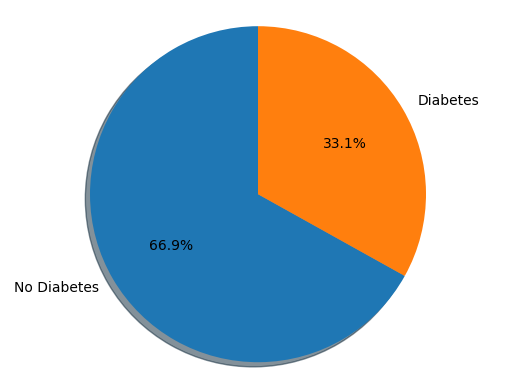

In [7]:
size0, size1 = df[Y].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=Y_labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


### Plot Protected Attributes

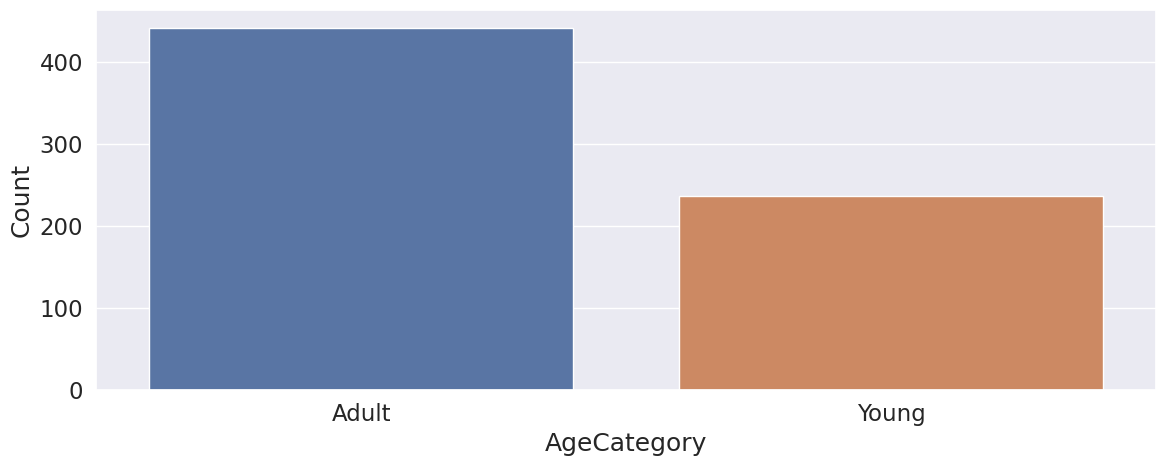

In [8]:
df_copy = df.copy()
df_copy[sensible_attribute] = df_copy[sensible_attribute].map(sensible_attribute_map)
for attribute in G:
    visualize_att_dist(df_copy, attribute, _category=True)

## Fairlearn
[Fairlearn](https://fairlearn.org) is an open source toolkit that empowers developers of artificial intelligence (AI) systems to assess their system's fairness and mitigate any observed unfairness issues.

### Train-test split
The dataset is split into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate the model. The test set is used to evaluate the model, and it should be kept separate from the training set. The test set should be used only once, and it should not be used to tune the model or to select features.

In [9]:
X=df[X]
y=df[Y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
y_true=df[Y].loc[list(X_test.index)]
sens_attr_df=df[sensible_attribute].loc[list(X_test.index)]

### Model training
The model chosen is a **Random Forest Classifier**, which is a supervised learning algorithm. It can be used both for classification and regression. It is a tree-based model, which means that it is built by combining several decision trees. It is a powerful model, and it is able to handle both numerical and categorical variables. It is also able to handle missing values, and it is not sensitive to outliers. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [10]:
classifier = RandomForestClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

### Metrics
The metrics used to evaluate the model are:
- `Accuracy`: The accuracy of the model, calculated as the number of correct predictions divided by the total number of predictions.
- `Precision`: The precision of the model, calculated as the number of true positives divided by the number of true positives plus the number of false positives.
- `False Positive Rate`: The false positive rate of the model, calculated as the number of false positives divided by the number of false positives plus the number of true negatives.
- `False Negative Rate`: The false negative rate of the model, calculated as the number of false negatives divided by the number of false negatives plus the number of true positives.
- `True Positive Rate`: The true positive rate of the model, calculated as the number of true positives divided by the number of true positives plus the number of false negatives.
- `Selection Rate`: The selection rate of the model, calculated as the number of positive predictions divided by the total number of predictions.
- `Count`: The number of predictions.

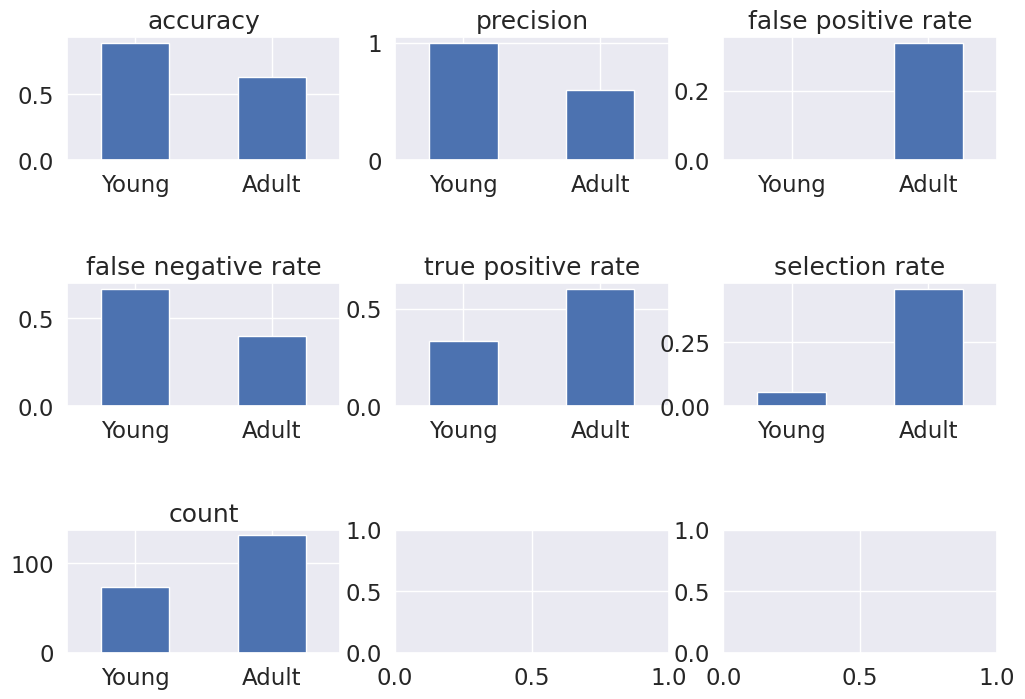

In [11]:
# Define the metrics to plot
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "true positive rate": recall_score,
    "selection rate": selection_rate,
    "count": count,
}

# Compute the metrics
metric_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attr_df)
metrics_result = metric_frame.by_group

# Set up the figure with subplots
ncols = 3
nrows = len(metrics) // 3
if(len(metrics) % 3 != 0):
    nrows += 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
sens_attr_df_mapped = sens_attr_df.map(sensible_attribute_map)

# Iterate over the metrics dictionary and plot each metric in a subplot
for i, (metric, values) in enumerate(metrics_result.items()):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    values.plot(kind="bar", ax=ax, title=metric)
    ax.set_xlabel("") # remove the sensitive attribute name
    ax.set_xticklabels(sens_attr_df_mapped.unique(), rotation=0)# rotate x-axis labels by 90 degrees

# Add spacing between the subplots
plt.subplots_adjust(hspace=1)

# Show the plot
plt.show()


In [12]:
metrics_result.head()

,accuracy,precision,false positive rate,false negative rate,true positive rate,selection rate,count
AgeCategory,,,,,,,
0,0.890411,1.0,0.000000,0.666667,0.333333,0.054795,73.0
1,0.633588,0.6,0.338028,0.400000,0.600000,0.458015,131.0


### Fairness Metrics
The fairness metrics used to evaluate the model are:
- `Demographic Parity`: The demographic parity of the model, calculated as the difference between the selection rate of the unprivileged group and the selection rate of the privileged group.
- `Equalized Odds`: The equalized odds of the model, calculated as the difference between the true positive rate of the unprivileged group and the true positive rate of the privileged group, and the difference between the false positive rate of the unprivileged group and the false positive rate of the privileged group.
- `Equal Opportunity`: The equal opportunity of the model, calculated as the difference between the true positive rate of the unprivileged group and the true positive rate of the privileged group.

In [13]:
# Calculate the metrics
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=sens_attr_df)
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=sens_attr_df)
equal_opportunity=metrics_result["true positive rate"][1]-metrics_result["true positive rate"][0]

panel_dem_parity = Panel(Align.center(str(dem_parity), vertical="middle"), title="[cyan]DEMOGRAPHIC PARITY");
panel_equalize_odds = Panel(Align.center(str(equalize_odds), vertical="middle"), title="[cyan]EQUALIZED ODDS");
panel_equal_opportunity = Panel(Align.center(str(equal_opportunity), vertical="middle"), title="[cyan]EQUAL OPPORTUNITY");
panel = Panel(Align.center(Columns([panel_dem_parity, panel_equalize_odds, panel_equal_opportunity]), vertical="middle"), title="FAIRNESS METRICS", padding=(1, 0))
print(panel)


╭─────────────────────────────────────────────── FAIRNESS METRICS ────────────────────────────────────────────────╮
│                                                                                                                 │
│                     ╭─ DEMOGRAPHIC PARITY ─╮ ╭── EQUALIZED ODDS ──╮ ╭─ EQUAL OPPORTUNITY ─╮                     │
│                     │  0.4032207466276273  │ │ 0.3380281690140845 │ │ 0.26666666666666666 │                     │
│                     ╰──────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## AIF360
[AIF360](https://aif360.mybluemix.net) is a system used in order to detect and mitigate a possible bias inside a dataset.
It requires firstly the identification of the corresponding protected attribute(sex,race,age etc..)

In order to use [AIF360](https://aif360.mybluemix.net) we need to define a Binary Dataset and split it into training and test set.

In [14]:
data_orig_age = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df.copy(),
    label_names=[Y],
    protected_attribute_names=G)

np.random.seed(42)

data_orig_age_train, data_orig_age_test = data_orig_age.split([0.7], shuffle=True)

### Model training
The model chosen is a **Random Forest Classifier**, which is a supervised learning algorithm. It can be used both for classification and regression. It is a tree-based model, which means that it is built by combining several decision trees. It is a powerful model, and it is able to handle both numerical and categorical variables. It is also able to handle missing values, and it is not sensitive to outliers. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [15]:
model = RandomForestClassifier().fit(data_orig_age_train.features,
                     data_orig_age_train.labels.ravel(),
                     sample_weight=data_orig_age_train.instance_weights)

### Bias metrics
A model can be considered bias if just one of these five metrics show that this model is biased.  


### For the AgeCategory attribute :

#### With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

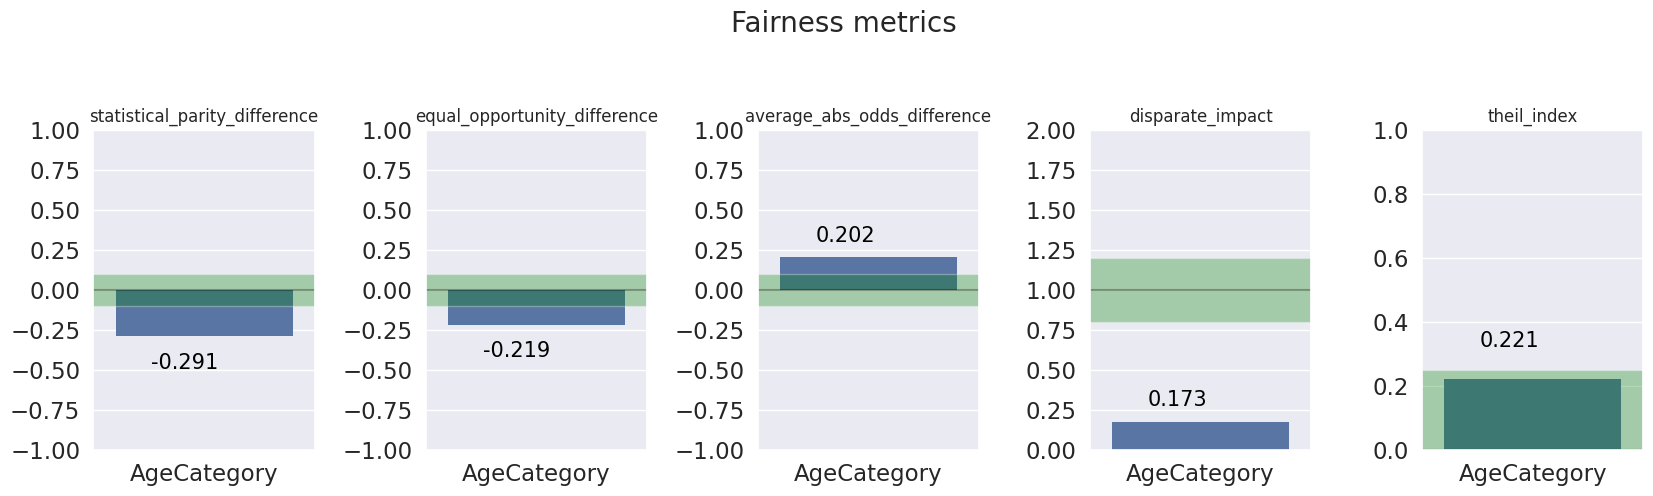

In [16]:
pred =  model.predict(data_orig_age_test.features)
fair = fair_metrics(data_orig_age_test, pred)
plot_fair_metrics(fair)